# Biodiversity Intactness Index change in Phoenix, AZ
### Author: Lucian Scher
### [Github Repository](https://github.com/lucianbluescher/Phoenix_BII_Change)

## About

This notebook analyzes changes in biodiversity intactness in the Phoenix, Arizona subdivision between 2017 and 2020 using the Biodiversity Intactness Index (BII) from Microsoft's Planetary Computer. The analysis quantifies the loss of high-quality habitat (BII ≥ 75%) to understand the impact of urban development on local biodiversity in the Phoenix metropolitan area.

### Highlights
- Geospatial data integration: Combines cloud-based biodiversity raster data from Microsoft Planetary Computer with U.S. Census Bureau vector data to perform spatial analysis at the subdivision level.

- Temporal biodiversity change quantification: Calculates that approximately 26.28 km² of land with high biodiversity intactness (BII ≥ 75%) was lost between 2017 and 2020 in the Phoenix subdivision, representing significant habitat degradation.

- Visualization: Creates both static and animated (GIF) visualizations to effectively communicate spatial and temporal patterns of biodiversity change, including a publication-quality map highlighting areas of biodiversity loss in Phoenix

- Reproducible cloud-based workflow: Demonstrates modern geospatial data science practices by accessing large Earth observation datasets directly from Azure Blob Storage using STAC API, eliminating the need for local data downloads.


## References


*Biodiversity Intactness Index (BII) Time Series*

[1] Microsoft Planetary Computer. (2025). Microsoft.com. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#Example-Notebook

*Phoenix Subdivision Shapefile*

[2] 2025 TIGER/Line® Shapefiles. (2025). Census.gov. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2025&layergroup=County+Subdivisions

‌

In [44]:
# Load required packages
import pandas as pd
import planetary_computer
import pystac_client
import geopandas as gpd
import rich.table
import stackstac
from geogif import gif
import contextily as ctx
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.colors import ListedColormap


## First dataset
The first dataset is hosted by the [Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview), I used their [Example notebook](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#Example-Notebook) to learn how to access this data from Azure Blob Storage. We'll use the [pystac-client](https://pystac-client.readthedocs.io/) Python package to search the Planetary Computer's STAC API for our Biodiversity Intactness Index (BII) Time Series data, and then we can load the data directly from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We just have to specify a modifier so that we can access the data stored in the Planetary Computer's private Blob Storage Containers.

In [7]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set our bounding box
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Pull out io-biodiversity collection
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

# List all available items 
items = list(search.items())
for item in items:
    print(item)

# Lets also display available assets 
asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Asset Title                     ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ Biodiversity Intactness         │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [4]:
# And see available properties
property_table = rich.table.Table("Property Name", "Property Value")
for key, value in sorted(items[-1].properties.items()):
    property_table.add_row(key, str(value))
property_table

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Property Name  ┃ Property Value                                                                                 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ datetime       │ None                                                                                           │
│ end_datetime   │ 2017-12-31T23:59:59Z                                                                           │
│ proj:code      │ EPSG:4326                                                                                      │
│ proj:shape     │ [7992, 7992]                                                                                   │
│ proj:transform │ [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215,                 │
│                │ 34.74464974521749, 0.0, 0.0, 1.0]                                                              │
│ start_datetime │ 2017-01-01T00:00:00Z                                                                           │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

## Second Dataset
The second dataset is a Phoenix Arizona subdivision shapefile from Census County Subdivision shapefiles for Arizona. It can be downloaded from through the U.S Census Bureau's TIGER shapefile portal. Just choose 2025, county subdivisions, press submit, then choose Arizona. 

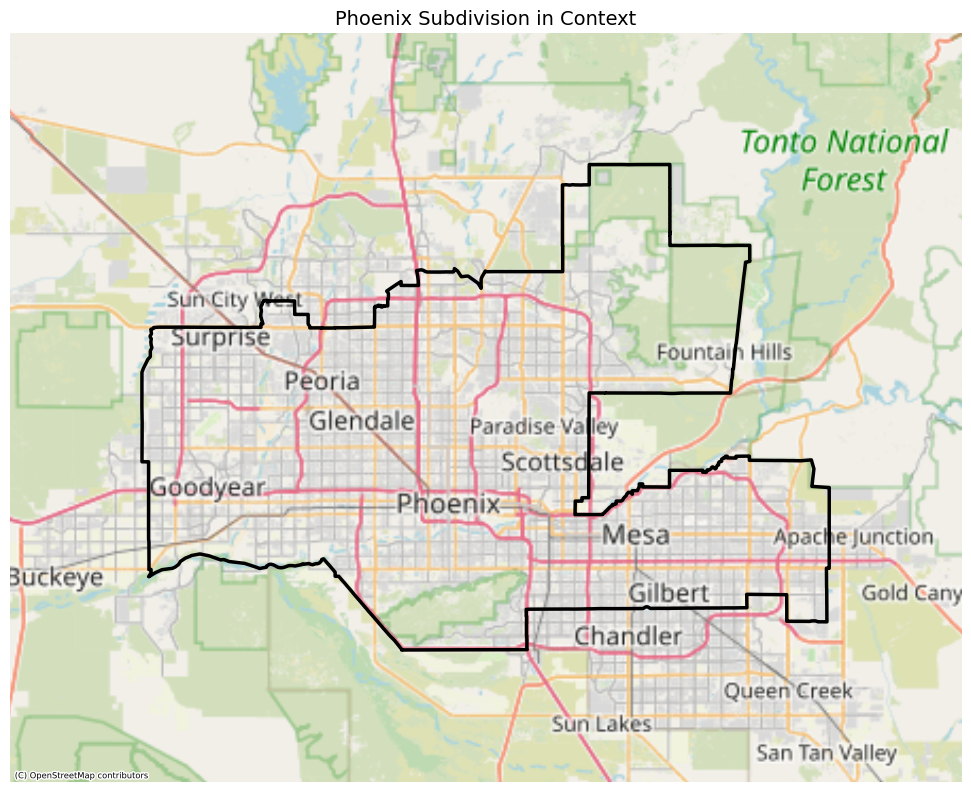

In [10]:
# First we load our shapefile
arizona = gpd.read_file("data/tl_2025_04_cousub")

# Next we can select the Phoenix area only
phoenix = arizona[arizona["NAME"].str.contains("Phoenix", case=False)]


# Change the CRS to Web Mercator for contextily package
arizona = arizona.to_crs(epsg=3857)
phoenix = phoenix.to_crs(arizona.crs)

# Now lets take a look at the Pheonix area in its surrounding context
fig, ax = plt.subplots(figsize=(10, 8))
phoenix.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=2.5,
    label="Phoenix subdivision",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9, attribution_size=6)

xmin, ymin, xmax, ymax = phoenix.total_bounds
pad = 19000
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title("Phoenix Subdivision in Context", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# Loading biodiversity data and inital plot
Let's take a quick look at our biodiversity data using the Web Mercator CRS so we can combine them later.

In [43]:
stack = (
    stackstac.stack(items, 
                    bounds_latlon=bbox_of_interest, 
                    assets=["data"],
                    epsg=3857)
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy(),
    ) 
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack

<xarray.DataArray 'Biodiversity Intactness' (time: 4, band: 1, y: 1015, x: 1830)> Size: 59MB
dask.array<getitem, shape=(4, 1, 1015, 1830), dtype=float64, chunksize=(1, 1, 1015, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
  * band            (band) <U4 16B 'data'
  * x               (x) float64 15kB -1.256e+07 -1.256e+07 ... -1.238e+07
  * y               (y) float64 8kB 4.011e+06 4.01e+06 ... 3.892e+06 3.892e+06
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    proj:shape      object 8B {7992}
    ...              ...
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    version         <U2 8B 'v1'
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    title           <U23 92B 'Biodiversity Intactness'
    epsg            int64 8B 3857
  * time            (time) datetime64[ns] 32B 2017-01-01 ... 2020-01-01
Attributes:
    spec:           RasterSpec(epsg=3857, bounds=(-12559899.91133213, 3891782...
    crs:            epsg:3857
    transform:      | 100.00, 0.00,-12559899.91|\n| 0.00,-116.99, 4010523.99|...
    resolution_xy:  (99.99999929404001, 116.9862897684553)

We still have not actually saved the biodiversity data yet so let's do that now. We use .squeeze() to remove the single `band` dimension and .compute() to load the data.

In [12]:
biodiversity_array = stack.squeeze().compute()

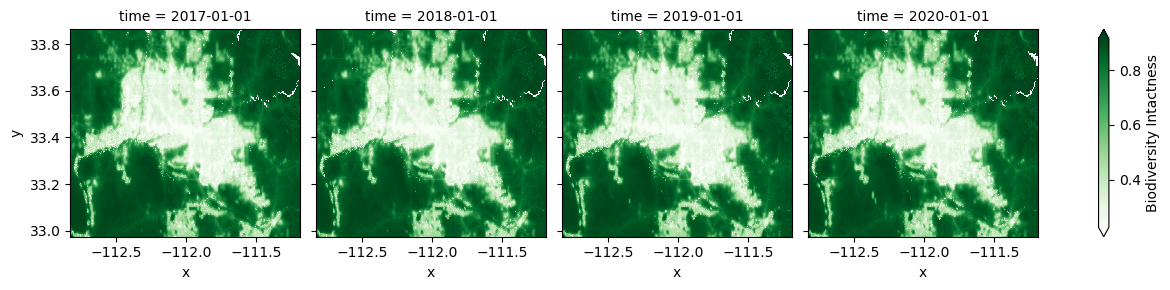

In [ ]:
# Now we can plot each year
az_bio = biodiversity_array.plot(col="time", cmap="Greens", robust=True)
az_bio

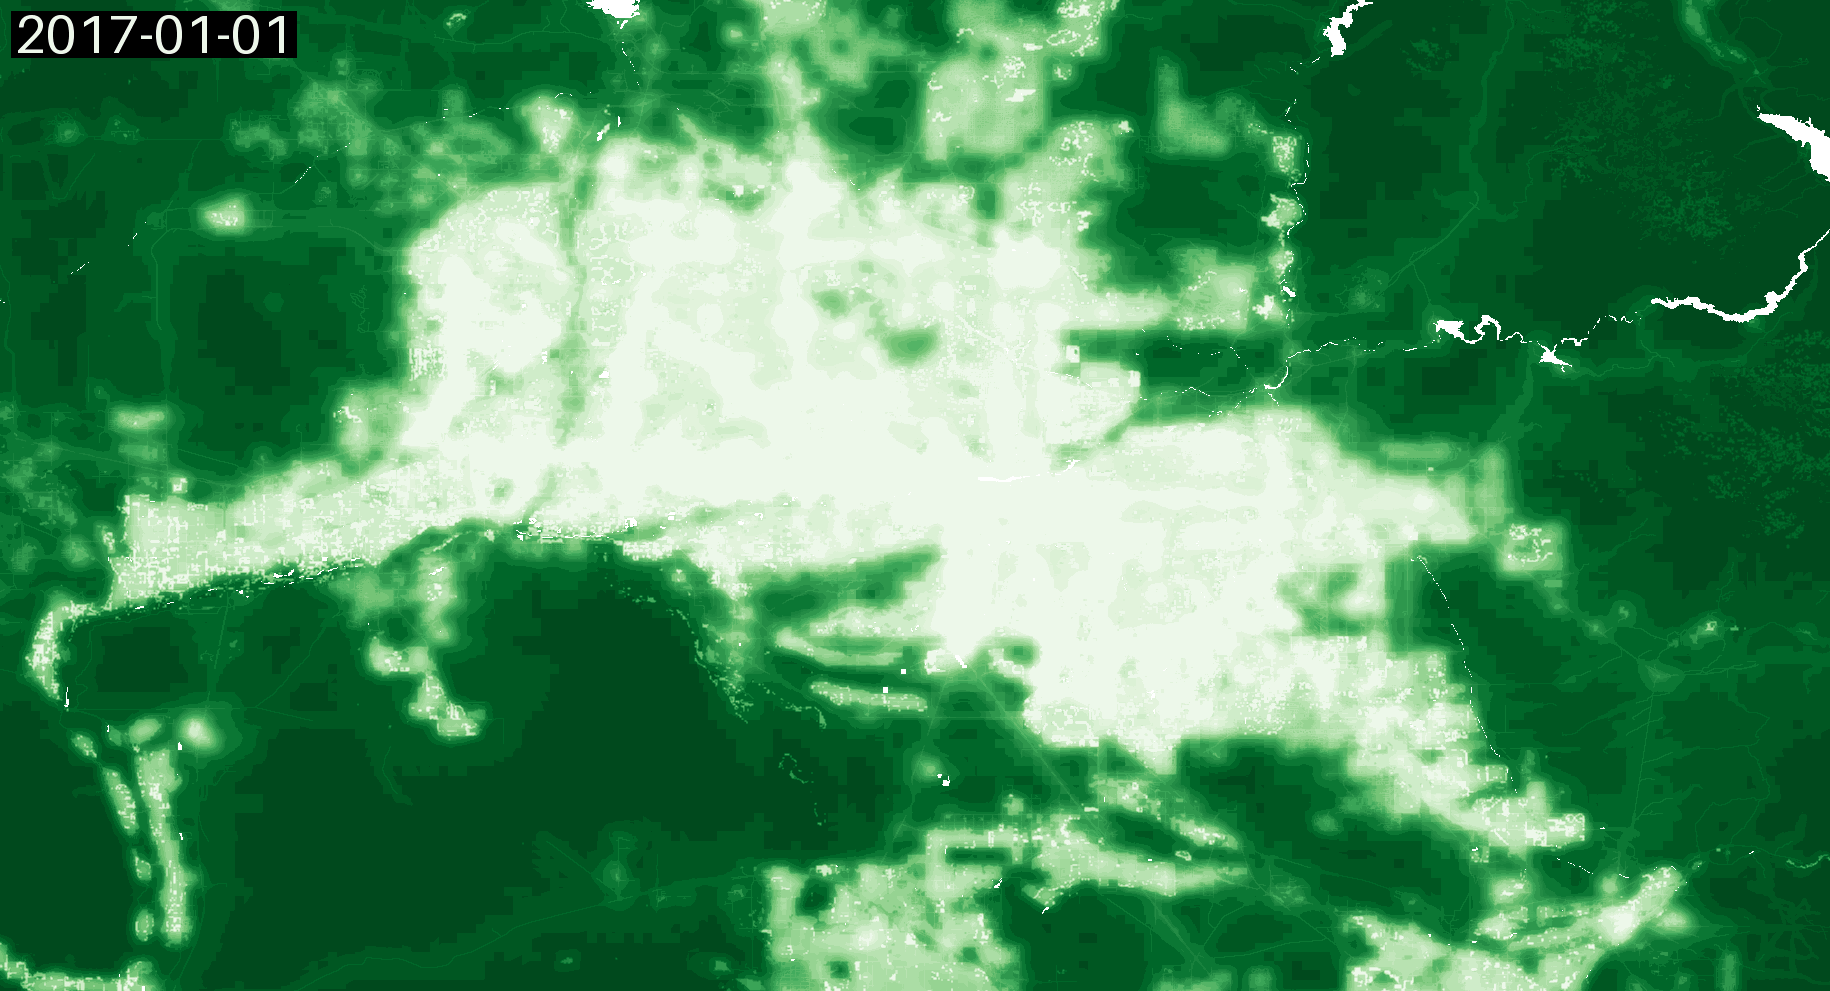

In [ ]:
# Lets make a gif and loop through the years so the change is more clear.
gif(biodiversity_array, fps=1, cmap="Greens", robust=True)

We want to see how much land with Biodiversity intactness greater than 75% was lost between 2017 and 2020. To do that we will first create an object for each year by selecting by time. Then we can create a mask where BII is greater than 75%

In [ ]:
# Select by year
bii_2017 = bii_phoenix.sel(time="2017-01-01T00:00:00")
bii_2020 = bii_phoenix.sel(time="2020-01-01T00:00:00")

# Create mask where BII is greater than 75%
mask_2017 = bii_2017 >= 0.75
mask_2020 = bii_2020 >= 0.75
# Calculate difference
loss_mask = mask_2017 & ~mask_2020

# Count how many raster cells dropped below 75%
loss_pixels = int(loss_mask.sum())

# Compute area in km2
pixel_area = biodiversity_array.rio.resolution()[0] * biodiversity_array.rio.resolution()[1]
loss_area_km2 = loss_pixels * pixel_area / 1e6

# Print our result
print(f"Loss pixels: {loss_pixels}, area ≈ {loss_area_km2:.2f} km²")

Loss pixels: 2246, area ≈ -26.28 km²


Now lets plot our result.

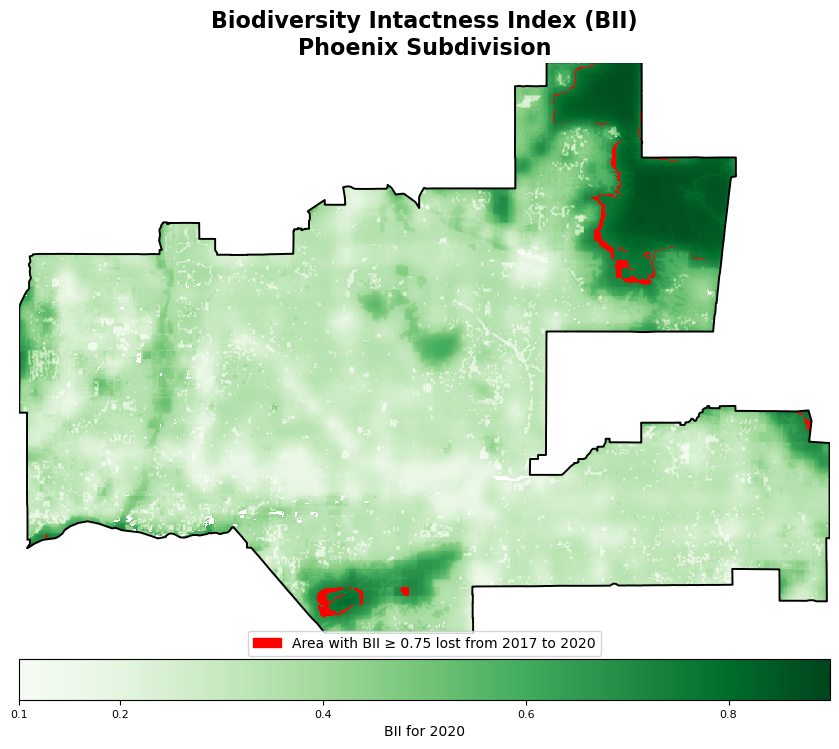

In [45]:

red_cmap = ListedColormap(["r"])
   
fig, ax = plt.subplots(figsize=(8.5, 9))

im = bii_2020.plot(
    ax=ax,
    cmap="Greens",
    vmin=0.1,
    vmax=0.9,
    add_colorbar=False,
    zorder=1,
)

loss_plot = loss_mask.where(loss_mask)
loss_plot.plot(
    ax=ax,
    cmap=red_cmap,
    add_colorbar=False,
    alpha=1.0,
    edgecolor="none",
    linewidth=0,
    zorder=3,
)

phoenix.boundary.plot(ax=ax, edgecolor="black", linewidth=1.4, zorder=4)

legend_elements = [patch.Patch(facecolor='red', edgecolor='r',
                         label='Area with BII ≥ 0.75 lost from 2017 to 2020')]

ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.03, fraction=0.05)
cbar.set_label("BII for 2020")
cbar.set_ticks([0.1, 0.2, 0.4, 0.6, 0.8])
cbar.ax.xaxis.set_tick_params(labelsize=8)

ax.set_title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision", fontsize=16, fontweight="bold")
ax.set_axis_off()
plt.tight_layout()